<a href="https://colab.research.google.com/github/IndraniMandal/CSC310-S20/blob/master/19a_NLP_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP & ML

We saw that we convert text document into a ‘vector model’ (bag-of-words).

The vector model allows us to perform mathematical analysis on documents - “which documents are similar to each other?”

> Next question: can we construct machine learning models on document collections using the vector model?

**Yes!** We can construct classifiers.


Consider again our news article data set.

We would like to construct a classifier that can correctly classifier political and science documents.

We will begin with our Decision Tree model.

And then apply  our KNN algorithm (k nearest neighbors). Since documents are considered point in an n-dimensional space KNN seems well suited for this problem.

## Data

In [2]:
# setup
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer

In [3]:
# compute 95% confidence intervals for classification and regression
# problems

def classification_confint(acc, n):
    '''
    Compute the 95% confidence interval for a classification problem.
      acc -- classification accuracy
      n   -- number of observations used to compute the accuracy
    Returns a tuple (lb,ub)
    '''
    import math
    interval = 1.96*math.sqrt(acc*(1-acc)/n)
    lb = max(0, acc - interval)
    ub = min(1.0, acc + interval)
    return (lb,ub)

In [5]:
print("******** data **********")

# get the newsgroup database
newsgroups = pd.read_csv("https://raw.githubusercontent.com/IndraniMandal/ds-assets/main/assets/newsgroups.csv")
newsgroups.head(n=10)

******** data **********


,text,label
0,From: demon@desire.wright.edu (Not a Boomer)\n...,space
1,From: dreitman@oregon.uoregon.edu (Daniel R. R...,space
2,From: mcgoy@unicorn.acs.ttu.edu (David McGaugh...,space
3,From: blh@uiboise.idbsu.edu (Broward L. Horne)...,space
4,From: wiggins@cecer.army.mil (Don Wiggins)\nSu...,space
5,From: nickh@CS.CMU.EDU (Nick Haines)\nSubject:...,politics
6,From: mike@gordian.com (Michael A. Thomas)\nSu...,space
7,From: jbreed@doink.b23b.ingr.com (James B. Ree...,politics
8,From: baalke@kelvin.jpl.nasa.gov (Ron Baalke)\...,politics
9,From: DPierce@world.std.com (Richard D Pierce)...,politics


In [7]:
print("******** docarray **********")

# build the stemmer object
stemmer = PorterStemmer()

# build a new default analyzer using CountVectorizer that only uses words: [a-zA-Z]+
# also eliminate stop words
analyzer= CountVectorizer(analyzer = "word", 
                          stop_words = 'english',
                          token_pattern = "[a-zA-Z]+").build_analyzer()

# build a new analyzer that stems using the default analyzer to create the words to be stemmed
def stemmed_words(doc):
    return [stemmer.stem(w) for w in analyzer(doc)]

# build docarray
vectorizer = CountVectorizer(analyzer=stemmed_words,
                             #analyzer=analyzer,
                             binary=True,
                             min_df=2) # each word has to appear at least twice
docarray = vectorizer.fit_transform(newsgroups['text']).toarray()
docarray.shape
doc_df = pd.DataFrame(docarray, columns=list(vectorizer.get_feature_names_out()))
doc_df.head()

******** docarray **********


,aa,aammmaaaazzzzzziinnnnggggg,aaron,ab,abandon,abbey,abc,abdkw,abett,abid,...,zimmer,zip,zippi,zj,zone,zoo,zoolog,zorba,zt,zv
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Decision Tree

In [29]:
print("******** model **********")


# Decision Tree
model = DecisionTreeClassifier(random_state=0)

# grid search
param_grid = {'max_depth': list(range(1,31))}
grid = GridSearchCV(model, param_grid, cv=5, verbose=10, n_jobs=-1)
grid.fit(docarray, newsgroups['label'])
print("Grid Search: best parameters: {}".format(grid.best_params_))
best_model = grid.best_estimator_

******** model **********
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Grid Search: best parameters: {'max_depth': 22}


[Ellipsis]

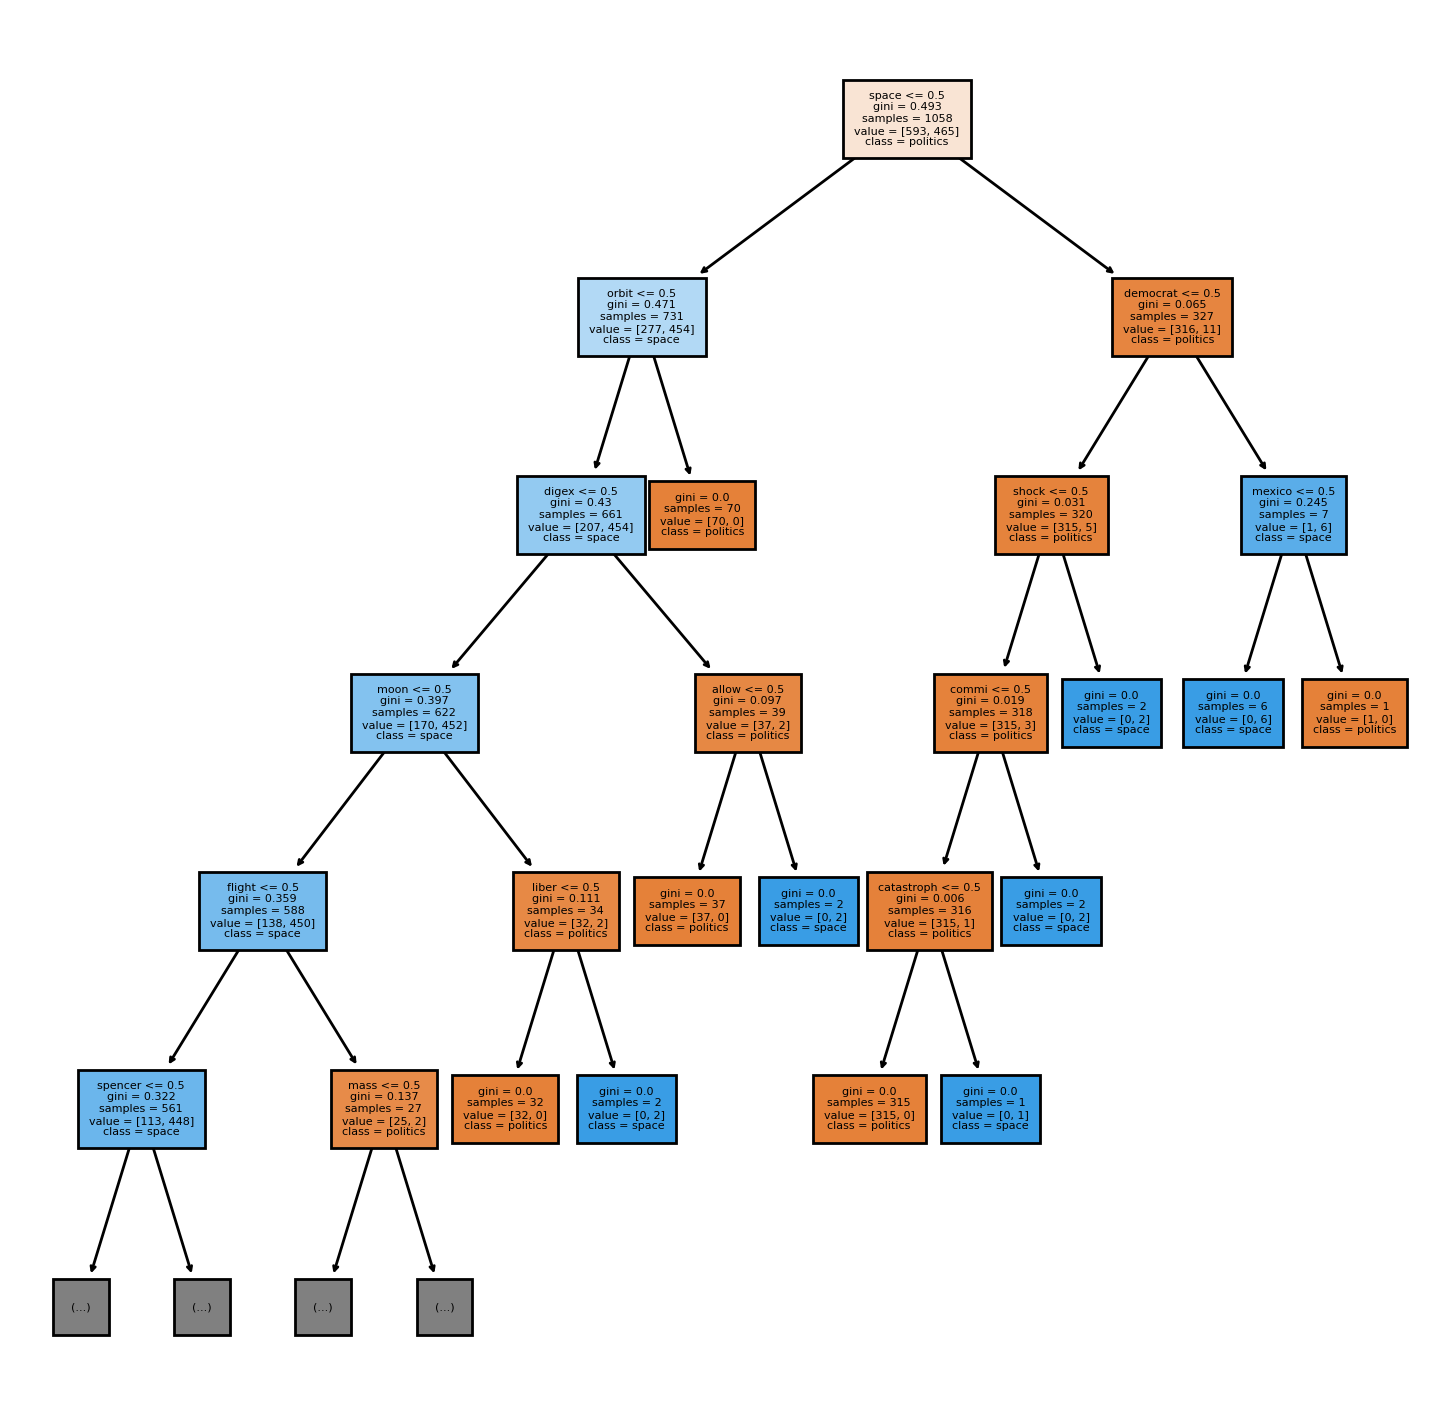

In [33]:
# Visualize the decision tree model
import matplotlib.pyplot as plt  # visualization library
from sklearn.tree import plot_tree
fig, axes = plt.subplots(1, 1, figsize=(9, 9), dpi=200)
plot_tree(best_model, fontsize=4, filled=True, 
               max_depth=5,
               feature_names= list(vectorizer.get_feature_names_out()),
               class_names= ['politics', 'space'])
[...]

In [21]:
print("******** Accuracy **********")

# accuracy of best model with confidence interval
predict_y = best_model.predict(docarray)
acc = accuracy_score(newsgroups['label'], predict_y)
lb,ub = classification_confint(acc,docarray.shape[0])
print("Accuracy: {:3.2f} ({:3.2f},{:3.2f})".format(acc,lb,ub))

******** Accuracy **********
Accuracy: 1.00 (1.00,1.00)


In [22]:
print("******** confusion matrix **********")

# build the confusion matrix
cats = ['politics','space']
cm = confusion_matrix(newsgroups['label'], predict_y, labels=cats)
cm_df = pd.DataFrame(cm, index=cats, columns=cats)
print("Confusion Matrix:\n{}".format(cm_df))

******** confusion matrix **********
Confusion Matrix:
          politics  space
politics       593      0
space            0    465


## KNN

In [23]:
print("******** model **********")


# KNN
model = KNeighborsClassifier()

# grid search
param_grid = {'n_neighbors': list(range(1,11))}
grid = GridSearchCV(model, param_grid, cv=5, verbose=10, n_jobs=-1)
grid.fit(docarray, newsgroups['label'])
print("Grid Search: best parameters: {}".format(grid.best_params_))

******** model **********
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Grid Search: best parameters: {'n_neighbors': 4}


In [24]:
print("******** Accuracy **********")

# accuracy of best model with confidence interval
best_model = grid.best_estimator_
predict_y = best_model.predict(docarray)
acc = accuracy_score(newsgroups['label'], predict_y)
lb,ub = classification_confint(acc,docarray.shape[0])
print("Accuracy: {:3.2f} ({:3.2f},{:3.2f})".format(acc,lb,ub))

******** Accuracy **********
Accuracy: 0.96 (0.95,0.98)


In [25]:
print("******** confusion matrix **********")

# build the confusion matrix
cats = ['politics','space']
cm = confusion_matrix(newsgroups['label'], predict_y, labels=cats)
cm_df = pd.DataFrame(cm, index=cats, columns=cats)
print("Confusion Matrix:\n{}".format(cm_df))

******** confusion matrix **********
Confusion Matrix:
          politics  space
politics       569     24
space           14    451


## Naive Bayes (NB)

* “Standard” model for text processing
* Fast to train, has no problems with very high dimensional data
* NB is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. 
* In simple terms, a NB classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature. 
* For example, a fruit may be considered to be an apple if it is red, round, and about 3 inches in diameter. Even if these features depend on each other or upon the existence of the other features, all of these properties independently contribute to the probability that this fruit is an apple and that is why it is known as ‘Naive’.


### The Mathematics

[Source](https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained)

Bayes theorem provides a way of calculating posterior probability $P(c|x)$ from $P(c)$, $P(x)$ and $P(x|c)$ with the equation, 

<center>
$
P(c|x) = \frac{P(x|c)P(c)}{P(x)}
$
</center>

where
  * $P(c|x)$ is the posterior probability of class (c, target) given predictor (x, attributes).
  * $P(c)$ is the prior probability of class.
  * $P(x|c)$ is the likelihood which is the probability of predictor given class.
  * $P(x)$ is the prior probability of predictor.



### Example

Let's assume we have a predictor `Weather` and a target `Play` that contains classes (left table below).  

<img src="https://www.analyticsvidhya.com/wp-content/uploads/2015/08/Bayes_41.png">

We want to compute if we play tennis when sunny.  That is we compute the two probabilities,

1. $P(Yes|Sunny)$
1. $P(No|Sunny)$

and then pick the statement with the higher probability.

Basically, NB just counts, let's look at $P(Yes|Sunny)$,

$P(Yes|Sunny) = \frac{P(Sunny|Yes)P(Yes)}{P(Sunny)} = \frac{3/9\times 9/14}{5/14} = \frac{.33 \times .64}{.36}=.60$

Now, let's look at $P(No|Sunny)$,

$P(No|Sunny) = \frac{P(Sunny|No)P(No)}{P(Sunny)} = \frac{2/5\times 5/14}{5/14} = \frac{.40 \times .36}{.36}=.40$

We are playing tennis when sunny because the posterior probability $P(Yes|Sunny)$ is higher.

Let’s take our text classification problem and use a Naive Bayes classifier on it.

The setup and data prep is the same as in the case of the KNN classifier.

In [ ]:

from sklearn.naive_bayes import MultinomialNB 
## Naive Bayes

print("******** model **********")


# Naive Bayes
model = MultinomialNB()
# NOTE: NB does not have any hyper-parameters - no overfitting - no searching over parameter space!
model.fit(docarray, newsgroups['label'])


print("******** Accuracy **********")

# accuracy of best model with confidence interval
best_model = model
predict_y = best_model.predict(docarray)
acc = accuracy_score(newsgroups['label'], predict_y)
lb,ub = classification_confint(acc,docarray.shape[0])
print("Accuracy: {:3.2f} ({:3.2f},{:3.2f})".format(acc,lb,ub))

print("******** confusion matrix **********")

# build the confusion matrix
cats = ['politics','space']
cm = confusion_matrix(newsgroups['label'], predict_y, labels=cats)
cm_df = pd.DataFrame(cm, index=cats, columns=cats)
print("Confusion Matrix:\n{}".format(cm_df))

Trains very fast and has a higher accuracy than DT or KNN and the difference in accuracy is statistically significant!

> NB does not have any hyper-parameters - no overfitting - no searching over parameter space!
